##### Colab-specific section (convert to code if needed)
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!unlink "/content/coopmotion"
!ln -s "/gdrive/My Drive/coopmotion/" "/content/coopmotion"
!rm -r "/content/coopmotion/dataset (1)" "/content/coopmotion/dataset" "/content/coopmotion/models"

In [ ]:
!rm -r "/content/coopmotion/notebook/videos"

In [ ]:
#!mv -r "/content/videos" "/content/coopmotion/notebook/videos"
!mv "/content/videos" "/content/coopmotion/notebook/videos"

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
sys.path.append('coopmotion/src') # COLAB
from matplotlib import pyplot as plt
import numpy as np
import torch
import time

from IPython.display import Audio
sound_file = './sound.wav'

# Learning

In [4]:
from task.square import SquareRun, proportional, sense, static_evenly_spread_task, static_zipf_task, shape_config
controller = proportional
N = 20
sas, tas = 1, 1

In [47]:
#from task.fancy import animate_trace
#trace = run()
#animate_trace(trace, dt=0.05)

In [48]:
number_of_samples = 10000
valid_part = 0.2
keep = 0.2

# Centralized Network

In [50]:
task = static_zipf_task(N, holonomic=True, spawn_area_size=sas, target_area_size=tas)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)

In [51]:
from task.dataset import generate_non_sequential_dataset, central_dataset
train_nseq = generate_non_sequential_dataset(run=run, number=number_of_samples, keep=keep, seed=0xDEADBEEF)
train_dataset, valid_dataset = central_dataset(train_nseq, valid_part)


train: x (8004, 20)	y (8004, 20)
valid: x (2001, 20)	y (2001, 20)


In [52]:
from keras_network import CentralizedNet
net = CentralizedNet(N, run.task.holonomic, patience=40)
history = net.train(epochs=200, train_dataset=train_dataset, valid_dataset=valid_dataset)

Train on 8004 samples, validate on 2001 samples
Epoch 1/200
8004/8004 [==============================] - 0s 60us/sample - loss: 0.0059 - mean_absolute_error: 0.0533 - val_loss: 0.0034 - val_mean_absolute_error: 0.0477
Epoch 2/200
8004/8004 [==============================] - 0s 35us/sample - loss: 0.0011 - mean_absolute_error: 0.0241 - val_loss: 9.3864e-04 - val_mean_absolute_error: 0.0228
Epoch 3/200
8004/8004 [==============================] - 0s 38us/sample - loss: 6.1495e-04 - mean_absolute_error: 0.0172 - val_loss: 6.3346e-04 - val_mean_absolute_error: 0.0160
Epoch 4/200
8004/8004 [==============================] - 0s 34us/sample - loss: 5.0000e-04 - mean_absolute_error: 0.0155 - val_loss: 4.4449e-04 - val_mean_absolute_error: 0.0141
Epoch 5/200
8004/8004 [==============================] - 0s 34us/sample - loss: 4.4655e-04 - mean_absolute_error: 0.0146 - val_loss: 6.8296e-04 - val_mean_absolute_error: 0.0167
Epoch 6/200
8004/8004 [==============================] - 0s 35us/sample - 

Epoch 92/200
8004/8004 [==============================] - 0s 32us/sample - loss: 9.9029e-05 - mean_absolute_error: 0.0076 - val_loss: 8.1433e-05 - val_mean_absolute_error: 0.0067
Epoch 93/200
8004/8004 [==============================] - 0s 33us/sample - loss: 9.9934e-05 - mean_absolute_error: 0.0076 - val_loss: 1.1831e-04 - val_mean_absolute_error: 0.0082
Epoch 94/200
8004/8004 [==============================] - 0s 33us/sample - loss: 9.8712e-05 - mean_absolute_error: 0.0075 - val_loss: 1.2066e-04 - val_mean_absolute_error: 0.0087
Epoch 95/200
8004/8004 [==============================] - 0s 32us/sample - loss: 9.7858e-05 - mean_absolute_error: 0.0075 - val_loss: 2.1702e-04 - val_mean_absolute_error: 0.0101
Epoch 96/200
8004/8004 [==============================] - 0s 31us/sample - loss: 9.8529e-05 - mean_absolute_error: 0.0076 - val_loss: 1.1600e-04 - val_mean_absolute_error: 0.0069
Epoch 97/200
8004/8004 [==============================] - 0s 32us/sample - loss: 9.7828e-05 - mean_absolu

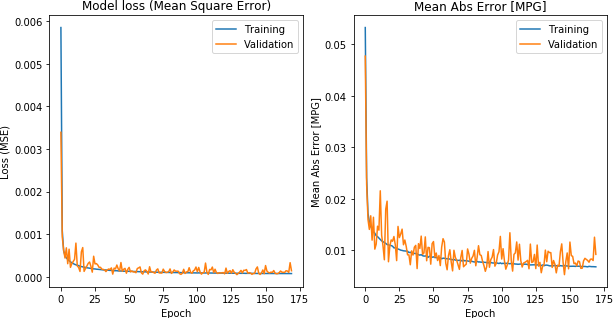

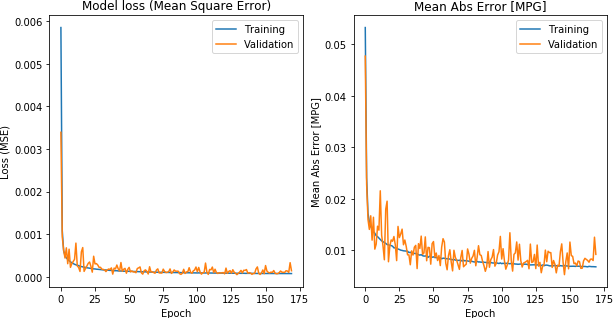

In [53]:
from task.fancy import training_plot
training_plot(history)

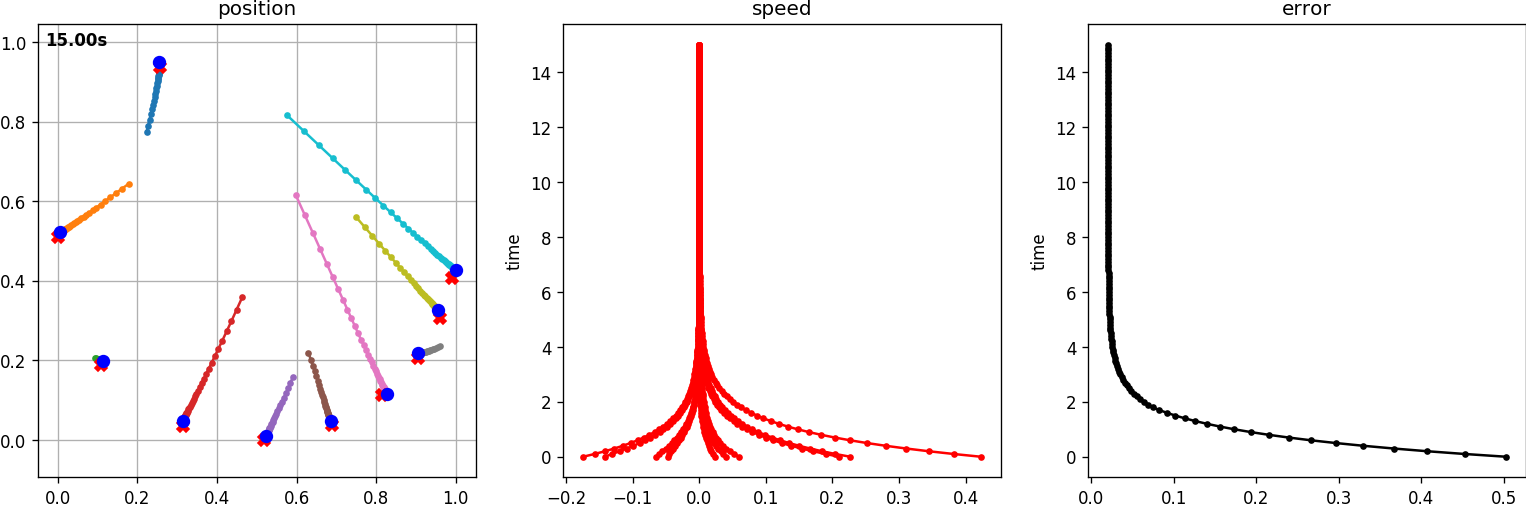

In [54]:
from task import Run
from task.fancy import plot_trace
net_controller = net.controller()
net_run = Run(task, sensor=run.sensor, dt=0.1, controller=net_controller)
c_trace = net_run(T=15, epsilon=0.01, seed=0xDEADBEEF)
plot_trace(c_trace, task)

In [55]:
from task.fancy import TracesAnimator
expert_trace = run(T=10, epsilon=0.01, seed=0xDEADBEEF)
TracesAnimator({'expert':expert_trace,'centralized': c_trace}, dt=0.05)

### How well are we controlling the agents?

In [56]:
from task.dataset import generate_sequential_dataset
comp_run, comp_duration, comp_steps = 100, 10, 50
exact_traces = generate_sequential_dataset(run, number=comp_run, duration=comp_duration, epsilon=0.01)
net_traces = generate_sequential_dataset(net_run, number=comp_run, duration=comp_duration, epsilon=0.01)
from task import prepare
exact_traces = [prepare(t, padding=True, steps=comp_steps) for t in exact_traces]
net_traces = [prepare(t, padding=True, steps=comp_steps) for t in net_traces]
time = exact_traces[0].time
exact_error = np.array([t.error for t in exact_traces])
net_error = np.array([t.error for t in net_traces])

Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)



Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)



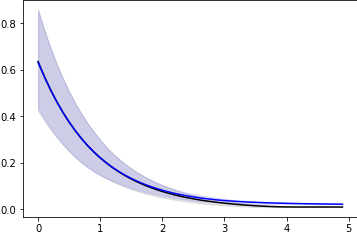

In [57]:
from task.fancy import plot_error
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')

## Distributed Network

In [19]:
from task.square import adaptive_evenly_spread_task, adaptive_zipf_task
task = adaptive_zipf_task(N, holonomic=True, spawn_area_size=sas, target_area_size=tas)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)
from task.dataset import distributed_dataset

In [15]:
number_of_samples = 1000
keep = 0.1
valid_part = 0.1
from keras_network import DistributedNet
from task.dataset import generate_non_sequential_dataset
d_net = DistributedNet(run=run, patience=10)

38



x (18018, 38)	y (18018, 2)
Train on 18018 samples, validate on 2002 samples
Epoch 1/50
18018/18018 [==============================] - 1s 72us/sample - loss: 0.0156 - mean_absolute_error: 0.0871 - val_loss: 0.0146 - val_mean_absolute_error: 0.0921
Epoch 2/50
18018/18018 [==============================] - 1s 57us/sample - loss: 0.0101 - mean_absolute_error: 0.0640 - val_loss: 0.0110 - val_mean_absolute_error: 0.0703
Epoch 3/50
18018/18018 [==============================] - 1s 56us/sample - loss: 0.0091 - mean_absolute_error: 0.0590 - val_loss: 0.0104 - val_mean_absolute_error: 0.0689
Epoch 4/50
18018/18018 [==============================] - 1s 52us/sample - loss: 0.0085 - mean_absolute_error: 0.0559 - val_loss: 0.0105 - val_mean_absolute_error: 0.0688
Epoch 5/50
18018/18018 [==============================] - 1s 66us/sample - loss: 0.0081 - mean_absolute_error: 0.0531 - val_loss: 0.0093 - val_mean_absolute_error: 0.0586
Epoch 6/50
18018/18018 [==============================] - 1s 59us/sa

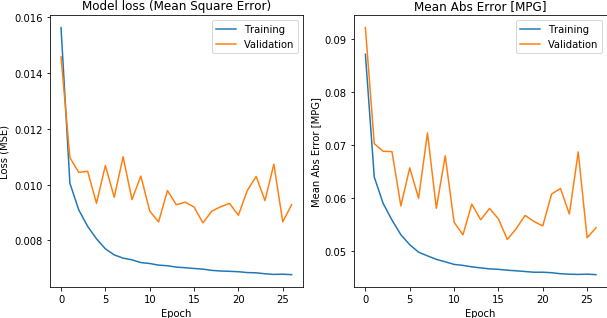

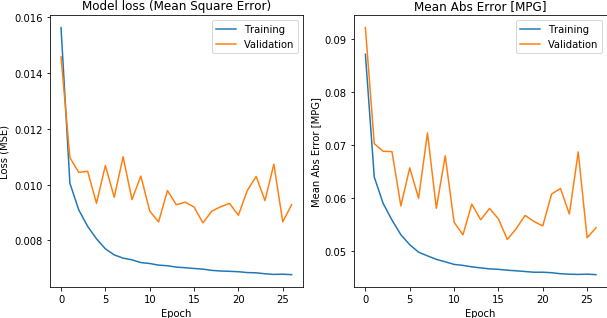


x (18018, 38)	y (18018, 2)
Train on 18018 samples, validate on 2002 samples
Epoch 1/50
18018/18018 [==============================] - 1s 42us/sample - loss: 0.0066 - mean_absolute_error: 0.0455 - val_loss: 0.0076 - val_mean_absolute_error: 0.0510
Epoch 2/50
18018/18018 [==============================] - 1s 43us/sample - loss: 0.0062 - mean_absolute_error: 0.0434 - val_loss: 0.0080 - val_mean_absolute_error: 0.0563
Epoch 3/50
18018/18018 [==============================] - 1s 44us/sample - loss: 0.0060 - mean_absolute_error: 0.0427 - val_loss: 0.0068 - val_mean_absolute_error: 0.0452
Epoch 4/50
18018/18018 [==============================] - 1s 44us/sample - loss: 0.0059 - mean_absolute_error: 0.0424 - val_loss: 0.0075 - val_mean_absolute_error: 0.0509
Epoch 5/50
18018/18018 [==============================] - 1s 44us/sample - loss: 0.0059 - mean_absolute_error: 0.0421 - val_loss: 0.0094 - val_mean_absolute_error: 0.0621
Epoch 6/50
18018/18018 [==============================] - 1s 43us/sa

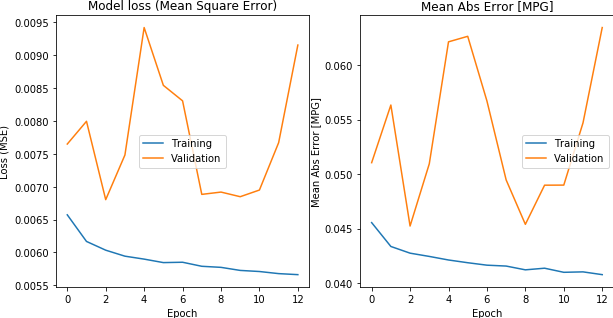

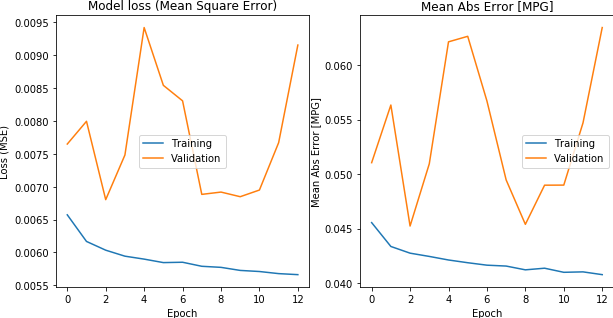

In [16]:
from task.fancy import training_plot
for _ in range(3):
    train_nseq = generate_non_sequential_dataset(run=run, number=number_of_samples, keep=keep)
    d_train_dataset, d_valid_dataset = distributed_dataset(train_nseq, valid_part)
    history = d_net.train(epochs=50, train_dataset=d_train_dataset, valid_dataset=d_valid_dataset)
    display(training_plot(history))

## Distributed Network - DAgger

In [ ]:
from keras_network import DistributedNet
d_net = DistributedNet(run=run, patience=10)
d_training_loss, d_testing_loss = [], []

from IPython.display import display, clear_output
from task.square import DaggerSquareRun
from task.fancy import pytorch_dagger_plot
from task.math import dagger_remappers

keep = 0.1
macroepochs = 100
samples_per_macroepoch = 1000
safe_limsup = 60
#_, net_ws = dagger_remappers(macroepochs,safe_limsup, 0)
#exp_ws = safe_limsup - net_ws
exp_ws = [30] * macroepochs
net_ws = [20] * macroepochs
for e in range(macroepochs):
    print(f"Epoch {e}")
    dagger_run = DaggerSquareRun(d_net, task, controller, run.sensor, 
                                 expert_window=exp_ws[e], net_window=net_ws[e], possessed_expert=False)
    train = generate_non_sequential_dataset(run=dagger_run, number=samples_per_macroepoch, disable_tqdm=False, keep=keep)
    d_train_dataset, d_valid_dataset = distributed_dataset(train_nseq, valid_part)
    d_net.train(epochs=50, train_dataset=d_train_dataset, valid_dataset=d_valid_dataset,
                         training_loss=d_training_loss, testing_loss=d_testing_loss, verbose=1)
    
    fig = pytorch_dagger_plot(d_training_loss, d_testing_loss, net_ws[:e], exp_ws[:e])
    
    display(fig)
    clear_output(wait = True)
    plt.pause(0.5)

### Distributed Network - Testing

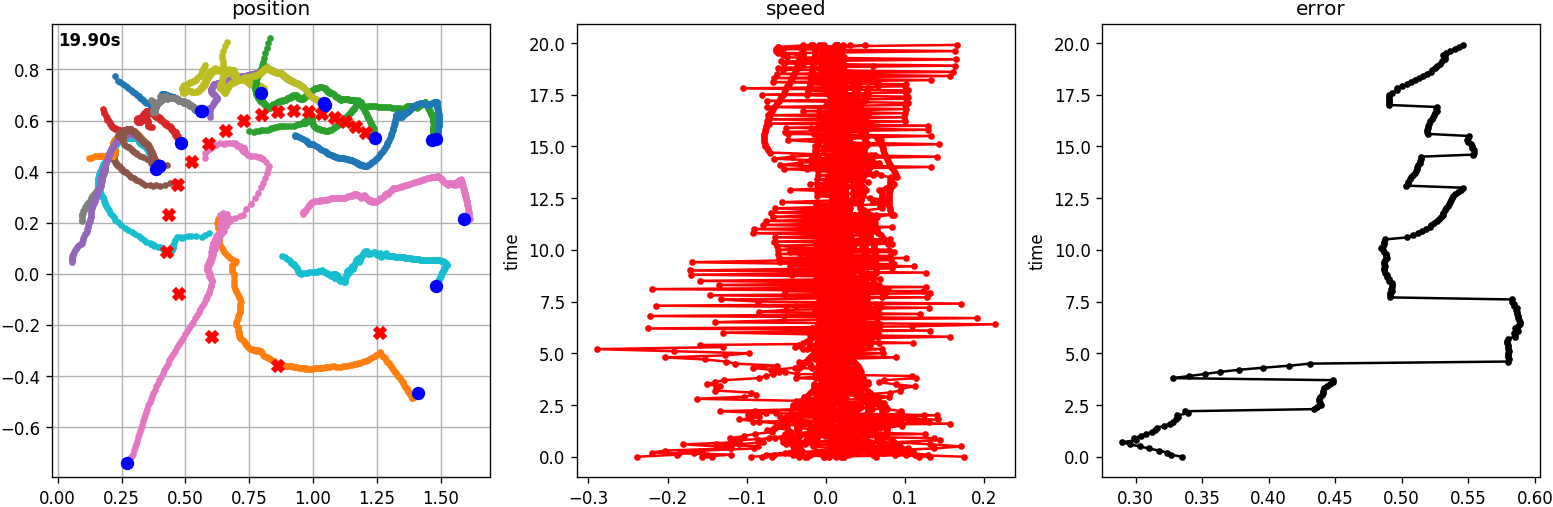

In [30]:
from task import Run
from task.fancy import plot_trace
d_net_controller = d_net.controller()
d_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=d_net_controller)
d_trace = d_net_run(T=20, epsilon=0.01, seed=0xDEADBEEF)
plot_trace(d_trace, task)

In [31]:
from task.fancy import TracesAnimator
expert_trace = run(T=10, epsilon=0.01, seed=0xDEADBEEF)
TracesAnimator({'expert':expert_trace,
                #'centralized': c_trace, 
                'distributed': d_trace}, dt=0.05)

In [32]:
d_net_traces = generate_sequential_dataset(d_net_run, number=100, duration=10, epsilon=0.01)
d_net_traces = [prepare(t, padding=True, steps=50) for t in d_net_traces]
d_net_error = np.array([t.error for t in d_net_traces])

NameError: name 'generate_sequential_dataset' is not defined

In [ ]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plt.legend()
plt.title('Error');

## Distributed Communicating Network

### Standard Training

In [32]:
from task.square import SquareRun
task = adaptive_zipf_task(N, spawn_area_size=sas, target_area_size=tas, holonomic=True)
run = SquareRun(task, controller=controller, sensor=sense(sorted=True, robot_range=10), dt=0.1)

In [33]:
steps = 2
number_of_samples = 80000
train_traces = generate_sequential_dataset(run=run, number=number_of_samples, steps=steps, keep=keep)
test_traces = generate_sequential_dataset(run=run, number=number_of_samples, steps=steps, keep=keep)
from task.dataset import sequence_dataset
cd_train_dataset = sequence_dataset(train_traces)
cd_test_dataset  = sequence_dataset(test_traces)
list(np.unique([x[0].shape[0] for x in cd_train_dataset]))


[2]

In [ ]:
from com_network import ComNet
from pytorch_network import train_net
cd_net = ComNet(N=N, broadcast=2)
cd_training_loss, cd_testing_loss = [], []

train_net(epochs=1, net=cd_net, train_dataset=cd_train_dataset, test_dataset=cd_test_dataset, batch_size=1, 
          training_loss=cd_training_loss, testing_loss=cd_testing_loss, disable_tqdm=False)

### Alternative Training

In [34]:
from com_network import ComNet
from pytorch_network import train_net
cd_net = ComNet(N=N, broadcast=2)
cd_training_loss, cd_testing_loss = [], []
steps = 2
number_of_samples = 80000

for _ in range(3):
    train_traces = generate_sequential_dataset(run=run, number=number_of_samples, steps=steps, keep=keep)
    test_traces = generate_sequential_dataset(run=run, number=number_of_samples, steps=steps, keep=keep)
    cd_train_dataset = sequence_dataset(train_traces)
    cd_test_dataset  = sequence_dataset(test_traces)
    train_net(epochs=1, net=cd_net, train_dataset=cd_train_dataset, test_dataset=cd_test_dataset, batch_size=1, 
              training_loss=cd_training_loss, testing_loss=cd_testing_loss, disable_tqdm=False)

100%|██████████| 1/1 [13:42<00:00, 822.04s/it]


([513.989962478081], [957.3987169240427])

## Distributed Communicating Network with Dagger

In [ ]:
from com_network import ComNet
from pytorch_network import train_net
cd_net = ComNet(N=N, broadcast=2)
cd_training_loss, cd_testing_loss = [], []
train_net(epochs=1, net=cd_net, train_dataset=cd_train_dataset, test_dataset=cd_test_dataset, batch_size=1, 
          training_loss=cd_training_loss, testing_loss=cd_testing_loss, disable_tqdm=False)

  0%|          | 0/1 [00:00<?, ?it/s]

[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4
  4  5  5  5  6  6  6  7  7  8  8  9 10 11 11 12 13 14 15 17 18 19 20 22
 23 24 26 27 28 30 31 32 33 35 36 37 38 39 39 40 41 42 42 43 43 44 44 44
 45 45 45 46 46 46 46 46 46 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47
 47 47 47 47] [48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 47 47 47 47 47
 47 46 46 46 45 45 45 44 44 43 43 42 41 40 40 39 38 37 36 34 33 32 31 29
 28 27 25 24 23 21 20 19 18 16 15 14 13 12 12 11 10  9  9  8  8  7  7  7
  6  6  6  5  5  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4]


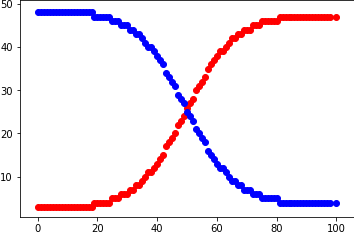

In [295]:
average_expert_iterations = np.mean([len(run().time) for _ in range(10)]).astype(int)
safe_limsup = int(average_expert_iterations*1.5)

from task.math import dagger_remappers
steps = 3
x, y = dagger_remappers(100, safe_limsup, steps, x_dilation = 3, y_dilation=1)

plt.scatter(x,y, color='r')
plt.scatter(x,safe_limsup-y, color='b')
len(y)
print(y, safe_limsup-y)

In [296]:
from IPython.display import display, clear_output
from task.square import DaggerSquareRun
from task.fancy import pytorch_dagger_plot
#import matplotlib.pyplot as plt
steps = 3
keep = 0.2
epochs = 40
samples_per_epoch = 10000
_, net_ws = dagger_remappers(epochs,safe_limsup, 0)
exp_ws = safe_limsup - net_ws
for e in range(0, epochs):
    dagger_run = DaggerSquareRun(cd_net, task, controller, run.sensor, 
                                 expert_window=exp_ws[e], net_window=net_ws[e])
    
    train_test = [generate_sequential_dataset(run=dagger_run, number=samples_per_epoch, disable_tqdm=True,
                                               steps=steps, keep=keep, duration=5) for _ in range(2)]
    cd_train_dataset, cd_test_dataset = [sequence_dataset(raw_data) for raw_data in train_test]
    
    train_net(epochs=1, net=cd_net, train_dataset=cd_train_dataset, test_dataset=cd_test_dataset, batch_size=1, 
          training_loss=cd_training_loss, testing_loss=cd_testing_loss, disable_tqdm=True)
    
    fig = pytorch_dagger_plot(cd_training_loss, cd_testing_loss, net_ws[:e], exp_ws[:e])
    
    display(fig)
    clear_output(wait = True)
    plt.pause(0.5)
#expert_dagger_trace = dagger_run(T=22, seed=0xDEADBEEF)
#plot_trace(expert_dagger_trace,task)

TypeError: dagger_remappers() missing 1 required positional argument: 'steps'

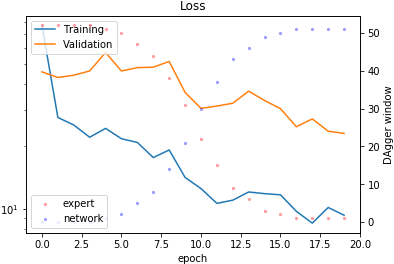

In [285]:
fig = pytorch_dagger_plot(cd_training_loss, cd_testing_loss, net_ws, exp_ws)

## Distributed Communicating Network - Testing

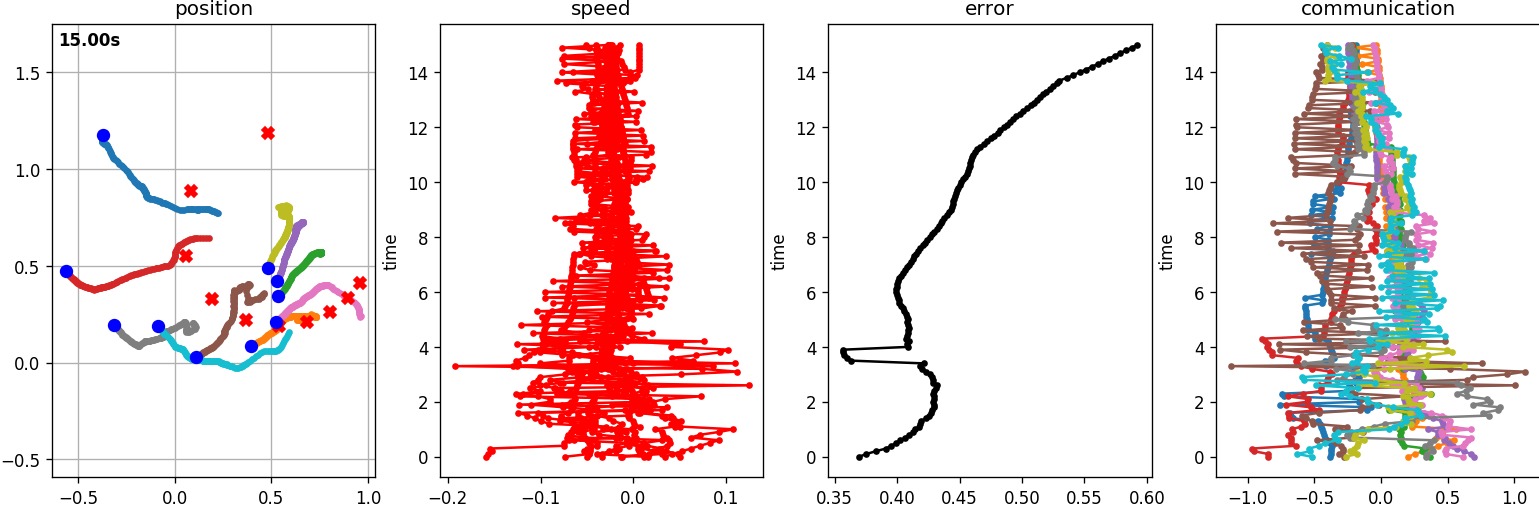

In [35]:
cd_net_controller = cd_net.controller()
cd_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=cd_net_controller)
cd_trace = cd_net_run(T=15, seed=0xDEADBEEF)
expert_trace = run(T=15, seed=0xDEADBEEF)
plot_trace(cd_trace,task)

In [36]:
# animate_trace(trace, robot_range=20, dt= 0.05)
traces_dict = {'expert':expert_trace,'centralized (static)': c_trace, 
               'distributed': d_trace, 'distributed (comm)': cd_trace}
TracesAnimator(traces_dict, robot_range=10, dt=0.05)

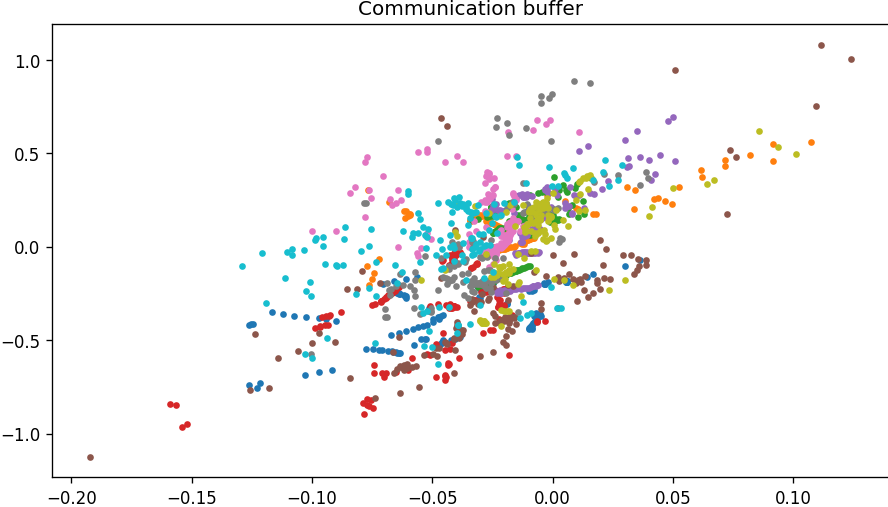

In [37]:
fig = plt.figure(figsize=(9, 5), dpi=120)
plt.plot(cd_trace.control[:,:,0], cd_trace.communication[:,0,:], '.');
plt.title('Communication buffer');

In [38]:
cd_net_traces = generate_sequential_dataset(cd_net_run, number=100, duration=5, epsilon=0.01)
cd_net_traces = [prepare(t, padding=True, steps=50) for t in cd_net_traces]
cd_net_error = np.array([t.error for t in cd_net_traces])

Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)



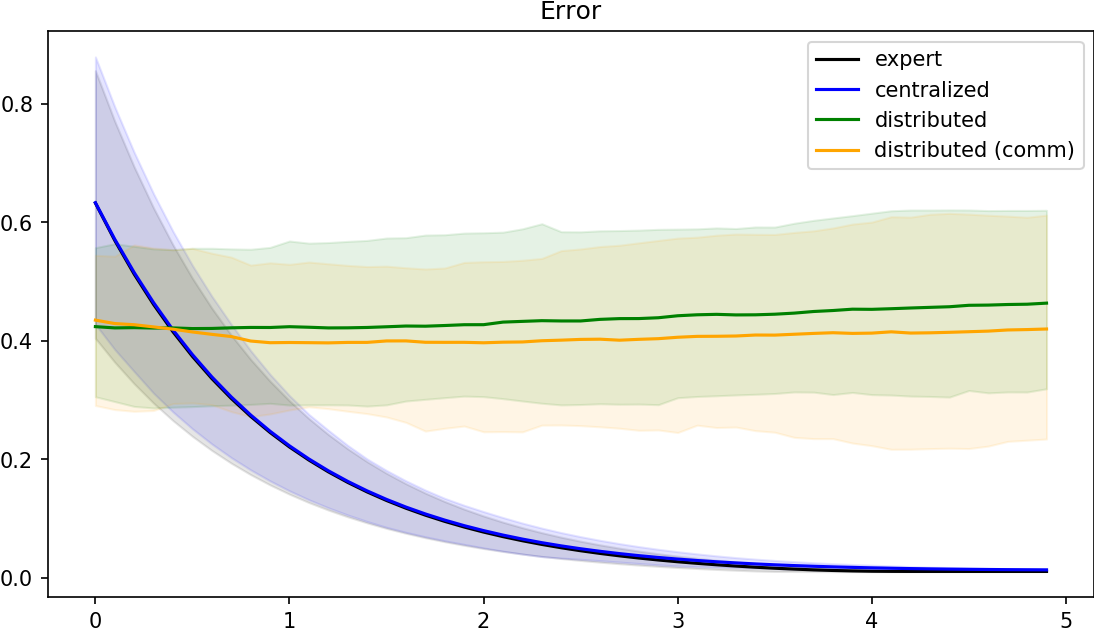

In [39]:
fig = plt.figure(figsize=(9, 5), dpi=150)
plot_error(time, exact_error, color='black', label='expert')
plot_error(time, net_error, color='blue', label='centralized')
plot_error(time, d_net_error, color='green', label='distributed')
plot_error(time, cd_net_error, color='orange', label='distributed (comm)')
plt.legend()
plt.title('Error');